# Pacotes

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import OLSInfluence
import itertools
import math




# 0. Os dados

## 0.1 FFF_LTfactor

In [82]:
FFF_LTfactor = pd.read_csv("Fama_French_Factors.csv", sep = ";")

In [83]:
display(FFF_LTfactor)

,Unnamed: 0,Rm-Rf,SMB,HML,RMW,CMA,RF,Mom,ST_Rev,LT_Rev
0,19900702,0.30,-0.39,-0.13,0.38,-0.12,0.032,0.77,-0.02,-0.32
1,19900703,0.13,-0.18,-0.35,0.50,-0.21,0.032,0.58,-0.17,-0.49
2,19900705,-1.04,0.44,0.02,-0.10,0.11,0.032,0.22,-0.23,0.13
3,19900706,0.61,-0.39,-0.25,0.31,-0.13,0.032,0.16,-0.21,-0.15
4,19900709,0.22,-0.32,-0.14,0.21,-0.40,0.032,0.35,-0.14,0.10
...,...,...,...,...,...,...,...,...,...,...
6420,20151224,-0.11,0.27,-0.04,-0.21,0.08,0.000,0.08,-0.13,-0.18
6421,20151228,-0.29,-0.53,-0.36,-0.01,-0.07,0.000,1.41,-1.09,-0.64
6422,20151229,1.05,0.03,-0.31,0.02,-0.34,0.000,0.23,0.21,-0.18
6423,20151230,-0.74,-0.17,-0.12,0.01,0.15,0.000,0.49,-0.50,-0.26


In [84]:
# cria coluna de datas baseado em unnamed
FFF_LTfactor["Date"] = pd.to_datetime(FFF_LTfactor["Unnamed: 0"], format="%Y%m%d")

In [85]:
# coloca a coluna data como indice
FFF_LTfactor = FFF_LTfactor.set_index("Date")

In [86]:
# exclui a coluna unnamed
FFF_LTfactor = FFF_LTfactor.drop(columns=["Unnamed: 0"])

In [87]:
# seleciona intervalos de crise

intervalos = [
    ("2000-03-24", "2001-09-21"),
    ("2002-01-04", "2002-10-09"),
    ("2007-10-09", "2008-11-20"),
    ("2009-01-06", "2009-03-09"),
]

FFF_LTfactor_crisis = pd.concat(
    [FFF_LTfactor.loc[inicio:fim] for inicio, fim in intervalos]
)


In [88]:
display(FFF_LTfactor)


,Rm-Rf,SMB,HML,RMW,CMA,RF,Mom,ST_Rev,LT_Rev
Date,,,,,,,,,
1990-07-02,0.30,-0.39,-0.13,0.38,-0.12,0.032,0.77,-0.02,-0.32
1990-07-03,0.13,-0.18,-0.35,0.50,-0.21,0.032,0.58,-0.17,-0.49
1990-07-05,-1.04,0.44,0.02,-0.10,0.11,0.032,0.22,-0.23,0.13
1990-07-06,0.61,-0.39,-0.25,0.31,-0.13,0.032,0.16,-0.21,-0.15
1990-07-09,0.22,-0.32,-0.14,0.21,-0.40,0.032,0.35,-0.14,0.10
...,...,...,...,...,...,...,...,...,...
2015-12-24,-0.11,0.27,-0.04,-0.21,0.08,0.000,0.08,-0.13,-0.18
2015-12-28,-0.29,-0.53,-0.36,-0.01,-0.07,0.000,1.41,-1.09,-0.64
2015-12-29,1.05,0.03,-0.31,0.02,-0.34,0.000,0.23,0.21,-0.18


In [89]:
display(FFF_LTfactor_crisis)

,Rm-Rf,SMB,HML,RMW,CMA,RF,Mom,ST_Rev,LT_Rev
Date,,,,,,,,,
2000-03-24,0.11,-0.38,-0.03,0.04,-0.21,0.020,-0.06,-0.12,-0.57
2000-03-27,-0.39,0.25,-0.45,-0.11,0.38,0.020,0.99,0.14,-0.04
2000-03-28,-1.34,-0.98,0.94,0.79,-0.04,0.020,-1.41,0.71,-0.15
2000-03-29,-1.00,-2.14,1.90,2.85,0.83,0.020,-2.84,-1.35,-1.09
2000-03-30,-1.76,-1.44,1.64,1.50,0.71,0.020,-3.43,-1.20,-0.76
...,...,...,...,...,...,...,...,...,...
2009-03-03,-0.71,-1.06,-2.42,-0.04,-0.85,0.001,0.36,-1.47,-0.71
2009-03-04,2.42,0.18,-0.97,-0.56,-0.12,0.001,-1.66,0.31,-0.86
2009-03-05,-4.21,-1.12,-3.01,0.64,0.06,0.001,3.32,-4.41,0.49


## 0.2 FFF_ret

In [90]:

FFF_ret = pd.read_csv("FFF_ret.csv")
display(FFF_ret)


,Unnamed: 0,Rm-Rf,SMB,HML,RMW,CMA,Rf,Mom,ST_Rev,Rp_ew_cc,Rp_ew_fi,Rp_vw_cc,Rp_vw_fi
0,01/07/1991,1.62,-1.10,-0.35,0.33,-0.53,0.022,0.71,0.72,0.000000,0.000000,0.000000,0.000000
1,02/07/1991,-0.12,0.00,-0.07,0.40,-0.13,0.022,0.26,-0.34,0.000000,0.000000,0.000000,0.000000
2,03/07/1991,-0.98,0.26,-0.09,0.03,0.11,0.022,0.23,-0.15,-0.000113,-0.001129,-0.000113,-0.001129
3,05/07/1991,0.17,-0.17,-0.11,0.07,0.01,0.022,0.09,0.34,0.000633,0.006334,0.000629,0.006299
4,08/07/1991,0.82,-0.54,-0.23,0.30,-0.49,0.022,0.41,0.89,0.000405,0.002701,0.000404,0.002685
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,24/12/2015,-0.11,0.28,-0.08,-0.15,0.08,0.000,0.08,-0.16,0.001576,0.001751,0.001634,0.001843
6169,28/12/2015,-0.28,-0.53,-0.35,0.10,-0.06,0.000,1.41,-1.08,-0.004772,-0.005303,-0.004378,-0.004936
6170,29/12/2015,1.05,0.03,-0.31,0.07,-0.34,0.000,0.20,0.20,0.001321,0.001468,0.001126,0.001270
6171,30/12/2015,-0.74,-0.18,-0.08,0.02,0.15,0.000,0.51,-0.45,-0.000131,-0.000145,0.000329,0.000371


In [91]:
# cria coluna datas baseada em unnamed

FFF_ret["Date"] = pd.to_datetime(FFF_ret["Unnamed: 0"], dayfirst=True) 

In [92]:
# transforma coluna date em indice
FFF_ret = FFF_ret.set_index("Date")

In [93]:
#salva o vetor dos retornos de Rp_vw_fi 
rf_vw_fi = FFF_ret["Rp_vw_fi"]

In [94]:
display(rf_vw_fi)

Date
1991-07-01    0.000000
1991-07-02    0.000000
1991-07-03   -0.001129
1991-07-05    0.006299
1991-07-08    0.002685
                ...   
2015-12-24    0.001843
2015-12-28   -0.004936
2015-12-29    0.001270
2015-12-30    0.000371
2015-12-31   -0.001366
Name: Rp_vw_fi, Length: 6173, dtype: float64

## 0.3 df final

In [95]:
# df é o dataframe dos fatores com a serie de retornos rf_vw_fi, conforme os intervalos de crise
df = FFF_LTfactor_crisis.join(rf_vw_fi, how="inner")


In [96]:
display(df)

,Rm-Rf,SMB,HML,RMW,CMA,RF,Mom,ST_Rev,LT_Rev,Rp_vw_fi
Date,,,,,,,,,,
2000-03-24,0.11,-0.38,-0.03,0.04,-0.21,0.020,-0.06,-0.12,-0.57,-0.011293
2000-03-27,-0.39,0.25,-0.45,-0.11,0.38,0.020,0.99,0.14,-0.04,-0.005916
2000-03-28,-1.34,-0.98,0.94,0.79,-0.04,0.020,-1.41,0.71,-0.15,0.003712
2000-03-29,-1.00,-2.14,1.90,2.85,0.83,0.020,-2.84,-1.35,-1.09,-0.014767
2000-03-30,-1.76,-1.44,1.64,1.50,0.71,0.020,-3.43,-1.20,-0.76,-0.003904
...,...,...,...,...,...,...,...,...,...,...
2009-03-03,-0.71,-1.06,-2.42,-0.04,-0.85,0.001,0.36,-1.47,-0.71,0.001790
2009-03-04,2.42,0.18,-0.97,-0.56,-0.12,0.001,-1.66,0.31,-0.86,0.006620
2009-03-05,-4.21,-1.12,-3.01,0.64,0.06,0.001,3.32,-4.41,0.49,-0.007071


In [97]:
# Criar a coluna de variável dependente (Excesso de retorno)
df["ExcessRet"] = df["Rp_vw_fi"] - df["RF"]

In [98]:
# organizando dataframe apenas com variáveis para a regressão
df = df.drop(columns=["RF", "Rp_vw_fi"])

In [99]:
display(df)

,Rm-Rf,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,ExcessRet
Date,,,,,,,,,
2000-03-24,0.11,-0.38,-0.03,0.04,-0.21,-0.06,-0.12,-0.57,-0.031293
2000-03-27,-0.39,0.25,-0.45,-0.11,0.38,0.99,0.14,-0.04,-0.025916
2000-03-28,-1.34,-0.98,0.94,0.79,-0.04,-1.41,0.71,-0.15,-0.016288
2000-03-29,-1.00,-2.14,1.90,2.85,0.83,-2.84,-1.35,-1.09,-0.034767
2000-03-30,-1.76,-1.44,1.64,1.50,0.71,-3.43,-1.20,-0.76,-0.023904
...,...,...,...,...,...,...,...,...,...
2009-03-03,-0.71,-1.06,-2.42,-0.04,-0.85,0.36,-1.47,-0.71,0.000790
2009-03-04,2.42,0.18,-0.97,-0.56,-0.12,-1.66,0.31,-0.86,0.005620
2009-03-05,-4.21,-1.12,-3.01,0.64,0.06,3.32,-4.41,0.49,-0.008071


In [100]:
# conferindo NA's

print(df.isna().sum())      
print(np.isfinite(df).all())

Rm-Rf          0
SMB            0
HML            0
RMW            0
CMA            0
Mom            0
ST_Rev         0
LT_Rev         0
ExcessRet    214
dtype: int64
Rm-Rf         True
SMB           True
HML           True
RMW           True
CMA           True
Mom           True
ST_Rev        True
LT_Rev        True
ExcessRet    False
dtype: bool


In [101]:
# excluindo NA's
df = df.dropna()

In [102]:
display(df)

,Rm-Rf,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,ExcessRet
Date,,,,,,,,,
2000-03-24,0.11,-0.38,-0.03,0.04,-0.21,-0.06,-0.12,-0.57,-0.031293
2000-03-27,-0.39,0.25,-0.45,-0.11,0.38,0.99,0.14,-0.04,-0.025916
2000-03-28,-1.34,-0.98,0.94,0.79,-0.04,-1.41,0.71,-0.15,-0.016288
2000-03-29,-1.00,-2.14,1.90,2.85,0.83,-2.84,-1.35,-1.09,-0.034767
2000-03-30,-1.76,-1.44,1.64,1.50,0.71,-3.43,-1.20,-0.76,-0.023904
...,...,...,...,...,...,...,...,...,...
2009-03-03,-0.71,-1.06,-2.42,-0.04,-0.85,0.36,-1.47,-0.71,0.000790
2009-03-04,2.42,0.18,-0.97,-0.56,-0.12,-1.66,0.31,-0.86,0.005620
2009-03-05,-4.21,-1.12,-3.01,0.64,0.06,3.32,-4.41,0.49,-0.008071


In [103]:
#conferindo NA's de novo
print(df.isna().sum())      
print(np.isfinite(df).all())

Rm-Rf        0
SMB          0
HML          0
RMW          0
CMA          0
Mom          0
ST_Rev       0
LT_Rev       0
ExcessRet    0
dtype: int64
Rm-Rf        True
SMB          True
HML          True
RMW          True
CMA          True
Mom          True
ST_Rev       True
LT_Rev       True
ExcessRet    True
dtype: bool


# 1. Exploração Inicial

## 1.1.1 Matriz de correlação e heatmap

In [104]:
# Matriz de correlação entre todas as variáveis independentes e dependentes
corr = df.corr()
display(corr)

,Rm-Rf,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,ExcessRet
Rm-Rf,1.000000,-0.147456,-0.096337,-0.460532,-0.482685,-0.415081,0.602146,-0.380663,0.086866
SMB,-0.147456,1.000000,0.020356,-0.263158,0.059910,0.147695,0.029826,0.349649,-0.115909
HML,-0.096337,0.020356,1.000000,0.318229,0.524037,-0.321891,-0.186960,0.475659,0.011028
RMW,-0.460532,-0.263158,0.318229,1.000000,0.616894,0.180668,-0.501806,0.099957,-0.026970
CMA,-0.482685,0.059910,0.524037,0.616894,1.000000,0.207587,-0.506506,0.530784,-0.047698
Mom,-0.415081,0.147695,-0.321891,0.180668,0.207587,1.000000,-0.221994,0.276335,-0.049918
ST_Rev,0.602146,0.029826,-0.186960,-0.501806,-0.506506,-0.221994,1.000000,-0.328786,0.114475
LT_Rev,-0.380663,0.349649,0.475659,0.099957,0.530784,0.276335,-0.328786,1.000000,-0.024902
ExcessRet,0.086866,-0.115909,0.011028,-0.026970,-0.047698,-0.049918,0.114475,-0.024902,1.000000


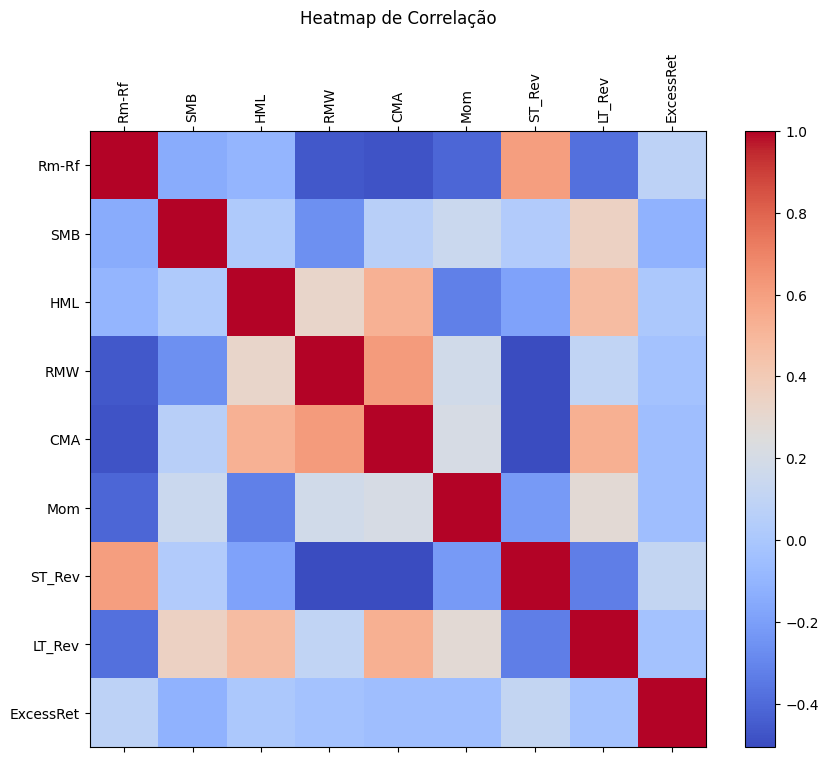

In [105]:

# heatmap das correlações

fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap="coolwarm")

# Barra de cores
plt.colorbar(cax)

# Colocar os nomes das variáveis no eixo
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.title("Heatmap de Correlação", pad=20)
plt.show()

In [106]:
# correlação de ExcessRet com as demais
corr_with_excess = corr["ExcessRet"].drop("ExcessRet")
print(corr_with_excess)

Rm-Rf     0.086866
SMB      -0.115909
HML       0.011028
RMW      -0.026970
CMA      -0.047698
Mom      -0.049918
ST_Rev    0.114475
LT_Rev   -0.024902
Name: ExcessRet, dtype: float64


## 1.1.2 Scaterplot de Y contra as demais

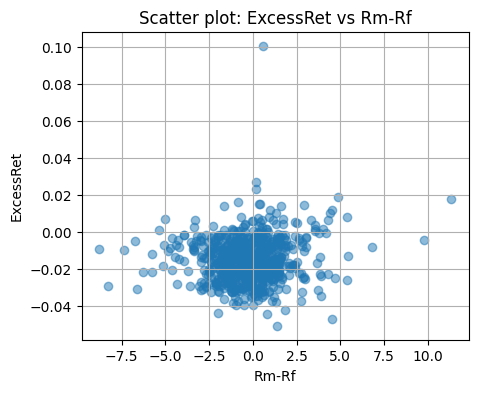

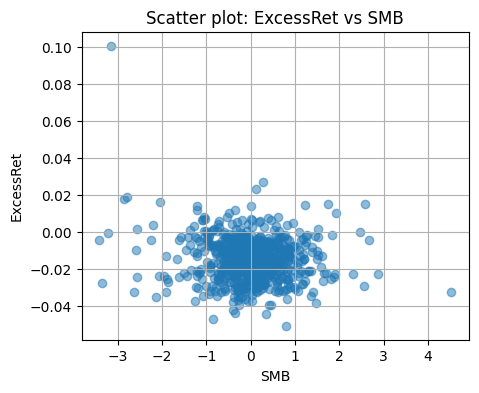

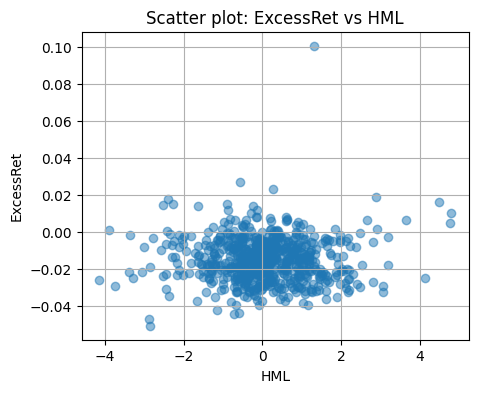

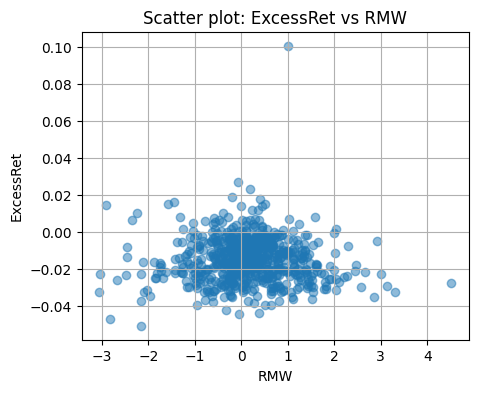

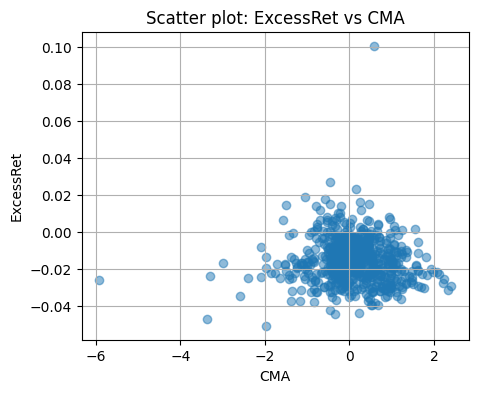

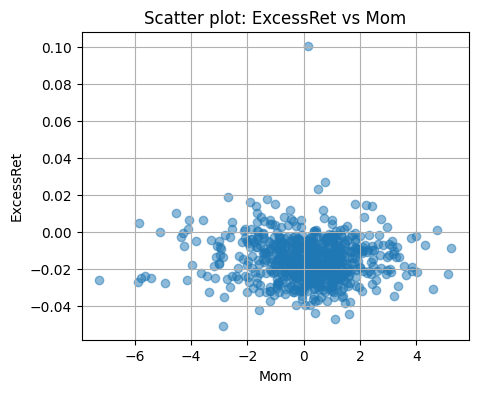

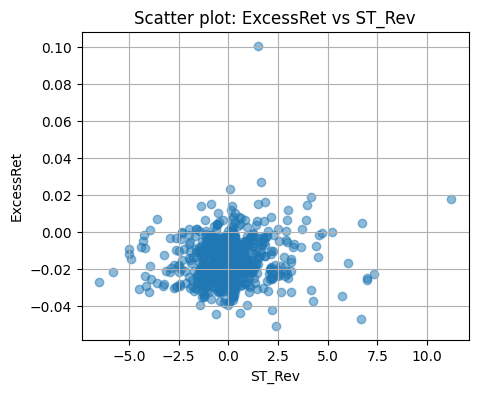

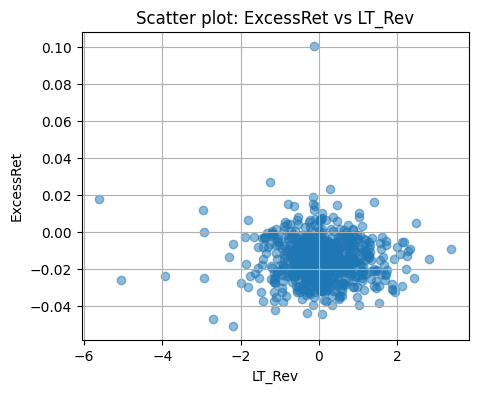

In [107]:
# observar scatterplot de Y contra demais

y = "ExcessRet"
X = ["Rm-Rf", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]

for col in X:
    plt.figure(figsize=(5,4))
    plt.scatter(df[col], df[y], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(y)
    plt.title(f"Scatter plot: {y} vs {col}")
    plt.grid(True)
    plt.show()

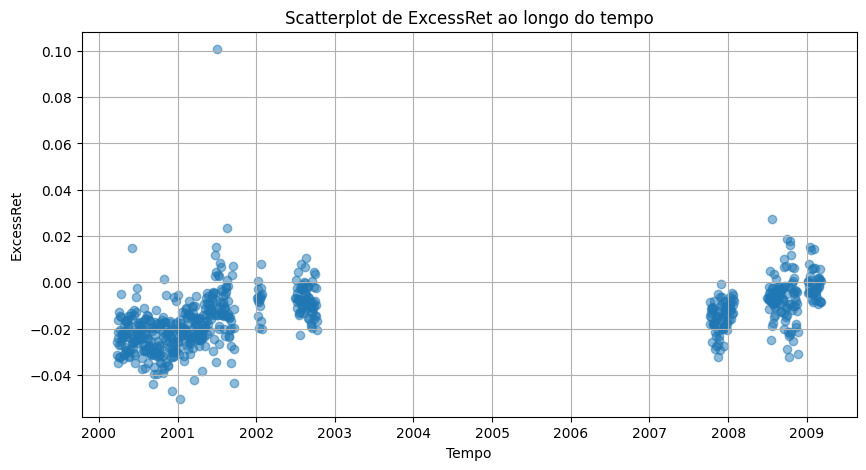

In [108]:
plt.figure(figsize=(10,5))
plt.scatter(df.index, df["ExcessRet"], alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("ExcessRet")
plt.title("Scatterplot de ExcessRet ao longo do tempo")
plt.grid(True)
plt.show()

## 1.1.3 Observação dos outliers: ordena outliers em ordem 


In [109]:
# ordena outliers em ordem 

outliers = df.sort_values(by="ExcessRet", ascending=False).head(5)
display(outliers)

,Rm-Rf,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,ExcessRet
Date,,,,,,,,,
2001-07-02,0.56,-3.16,1.32,1.00,0.59,0.14,1.49,-0.12,0.100693
2008-07-21,0.16,0.27,-0.57,-0.08,-0.47,0.75,1.64,-1.25,0.027124
2001-08-16,0.21,0.12,0.26,0.19,0.16,0.52,0.07,0.27,0.023534
2008-09-30,4.88,-2.80,2.88,-0.20,-1.06,-2.67,4.14,-0.15,0.018794
2008-10-13,11.35,-2.87,-2.39,0.40,-0.58,-1.30,11.22,-5.61,0.017642


Observou-se um valor destoante no dia 02/07/2001. Na sexta anterior (29/06/2001) o Nasdaq sofreu uma falha técnica que interrompeu o pregão por ~1h e gerou preços de fechamento incorretos para dezenas de ações (incluindo blue chips como Microsoft/Dell). No fim de semana e na segunda (02/07/2001) a bolsa reprocessou/ajustou vários preços, o que afetou índices e carteiras ponderadas por valor de mercado.

Foi decidido então, retirar a observação relativa ao dia 02/07/2001

fonte: https://www.wired.com/2001/07/big-blunder-at-nasdaq/

## 1.2.1 Segunda Exploração inicial (sem 2001-07-02): matriz de correlação e heatmap

In [110]:
# excluindo outliers

df = df.drop(index="2001-07-02")

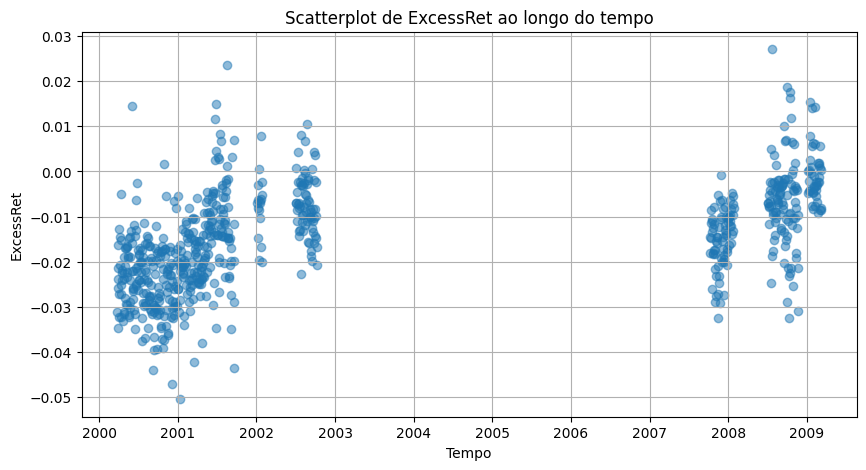

In [111]:
plt.figure(figsize=(10,5))
plt.scatter(df.index, df["ExcessRet"], alpha=0.5)
plt.xlabel("Tempo")
plt.ylabel("ExcessRet")
plt.title("Scatterplot de ExcessRet ao longo do tempo")
plt.grid(True)
plt.show()

## 1.2.2 Matriz de correlação e heatmap

In [112]:
# Matriz de correlação
corr = df.corr()
display(corr)

,Rm-Rf,SMB,HML,RMW,CMA,Mom,ST_Rev,LT_Rev,ExcessRet
Rm-Rf,1.000000,-0.146734,-0.097082,-0.461433,-0.483281,-0.415138,0.602026,-0.380611,0.087109
SMB,-0.146734,1.000000,0.026631,-0.260966,0.064179,0.149329,0.034938,0.352383,-0.068418
HML,-0.097082,0.026631,1.000000,0.317244,0.523626,-0.322179,-0.188560,0.476359,-0.004271
RMW,-0.461433,-0.260966,0.317244,1.000000,0.616596,0.180767,-0.503534,0.100265,-0.042784
CMA,-0.483281,0.064179,0.523626,0.616596,1.000000,0.207641,-0.507731,0.531127,-0.060875
Mom,-0.415138,0.149329,-0.322179,0.180767,0.207641,1.000000,-0.222124,0.276344,-0.053752
ST_Rev,0.602026,0.034938,-0.188560,-0.503534,-0.507731,-0.222124,1.000000,-0.328744,0.110243
LT_Rev,-0.380611,0.352383,0.476359,0.100265,0.531127,0.276344,-0.328744,1.000000,-0.024040
ExcessRet,0.087109,-0.068418,-0.004271,-0.042784,-0.060875,-0.053752,0.110243,-0.024040,1.000000


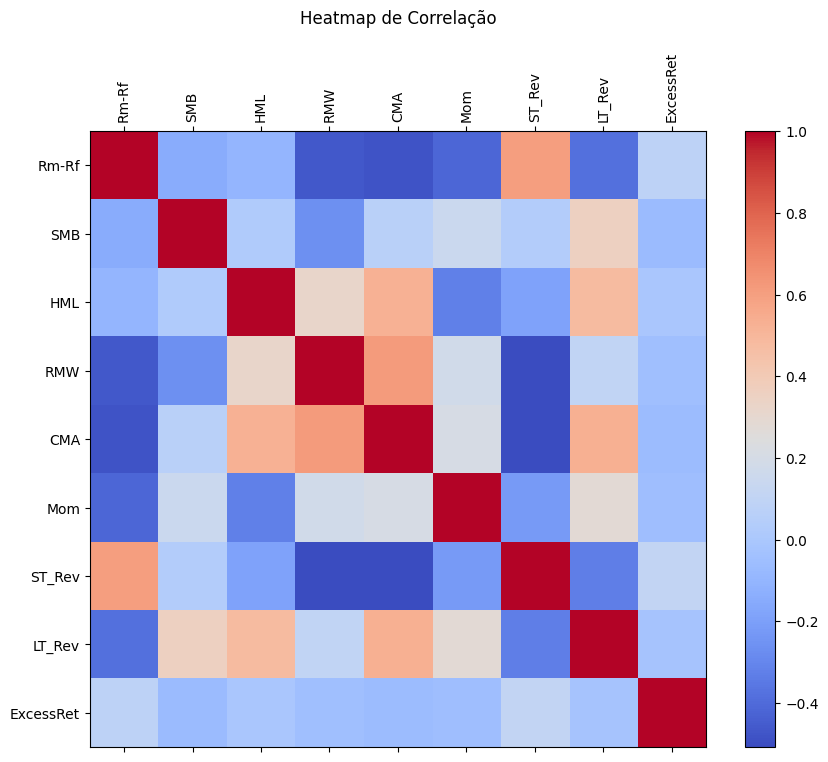

In [113]:
# heatmap das correlações

fig, ax = plt.subplots(figsize=(10,8))
cax = ax.matshow(corr, cmap="coolwarm")

# Barra de cores
plt.colorbar(cax)

# Colocar os nomes das variáveis no eixo
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

plt.title("Heatmap de Correlação", pad=20)
plt.show()

In [114]:
# correlação de ExcessRet com as demais
corr_with_excess = corr["ExcessRet"].drop("ExcessRet")
print(corr_with_excess)

Rm-Rf     0.087109
SMB      -0.068418
HML      -0.004271
RMW      -0.042784
CMA      -0.060875
Mom      -0.053752
ST_Rev    0.110243
LT_Rev   -0.024040
Name: ExcessRet, dtype: float64


## 1.2.3 Scatterplot de Y contra as demais

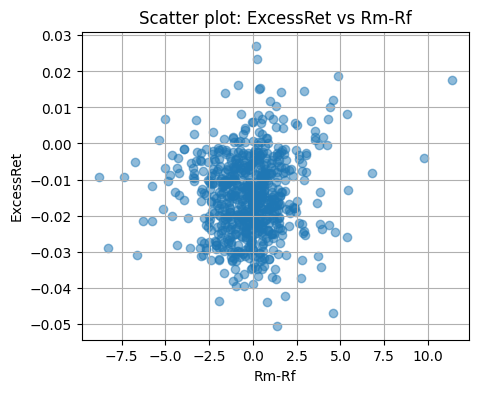

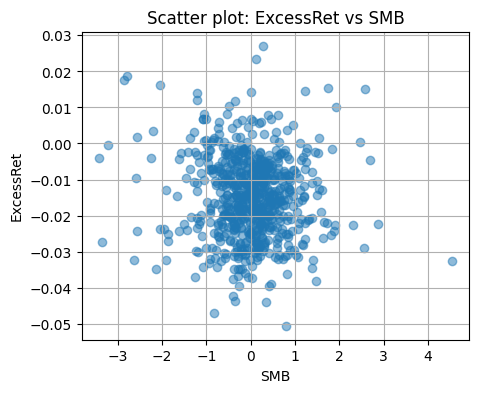

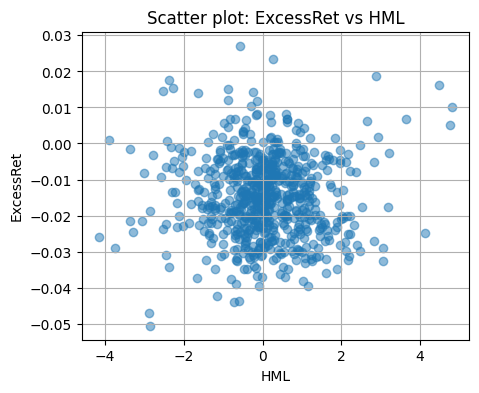

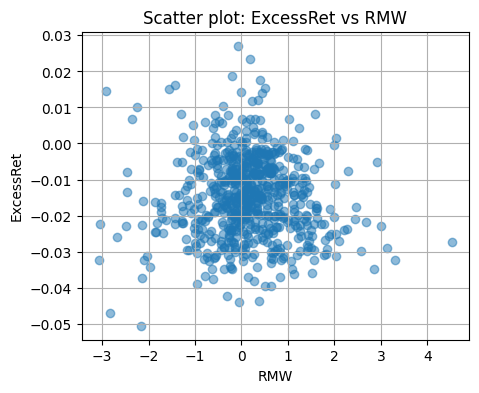

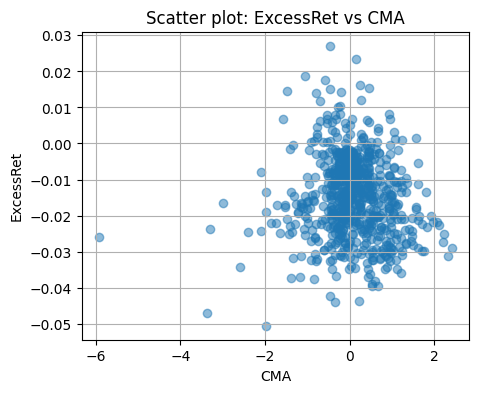

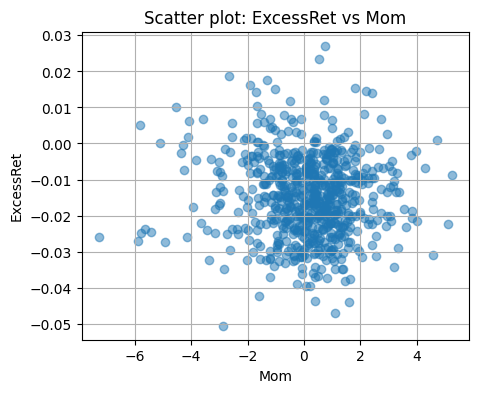

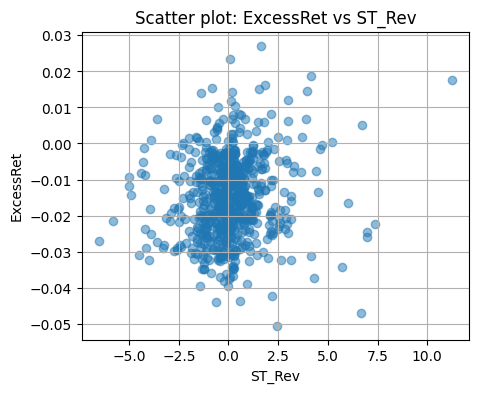

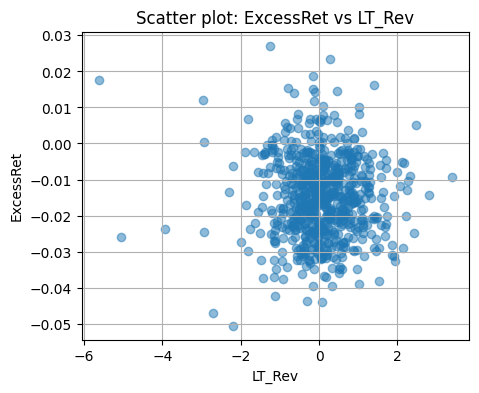

In [115]:
# observar scatterplot de Y contra demais

y = "ExcessRet"
X = ["Rm-Rf", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]

for col in X:
    plt.figure(figsize=(5,4))
    plt.scatter(df[col], df[y], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel(y)
    plt.title(f"Scatter plot: {y} vs {col}")
    plt.grid(True)
    plt.show()

A dispersão das relações das variáveis X com variável Y não indicam linearidade.

# 2. Ajuste do Modelo Inicial

In [116]:
# aplicando a regressao

Y = df["ExcessRet"]
X = df[["Rm-Rf", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]]
X_const = sm.add_constant(X)


model = sm.OLS(Y, X_const).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.787
Date:                Thu, 16 Oct 2025   Prob (F-statistic):             0.0766
Time:                        17:18:19   Log-Likelihood:                 2086.8
No. Observations:                 679   AIC:                            -4156.
Df Residuals:                     670   BIC:                            -4115.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0148      0.000    -33.212      0.0

Observa-se constante negativa e signicancia da média apenas para variável ST_Rev e possivelmente SMB

## 2.1 observando os residuos

In [117]:
resid = model.resid  # resíduos
fitted = model.fittedvalues  # valores ajustados

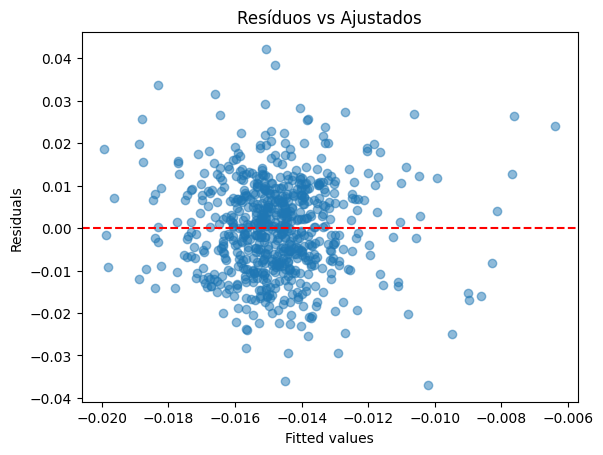

In [118]:
# Resíduos vs Valores Ajustados (checando homocedasticidade)
plt.scatter(fitted, resid, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Resíduos vs Ajustados")
plt.show()

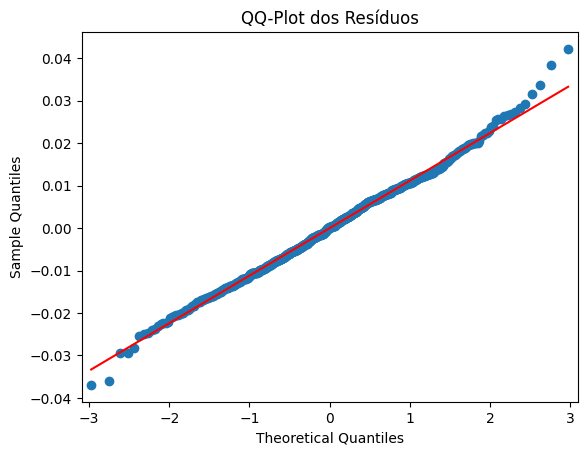

In [119]:
# QQ-plot (checando normalidade)
sm.qqplot(resid, line="s")
plt.title("QQ-Plot dos Resíduos")
plt.show()

Os resíduos são aproximadamente normais no centro, mas não seguem bem a normalidade nas caudas. Esta é uma observação natural para em séries de ativos financeiros.

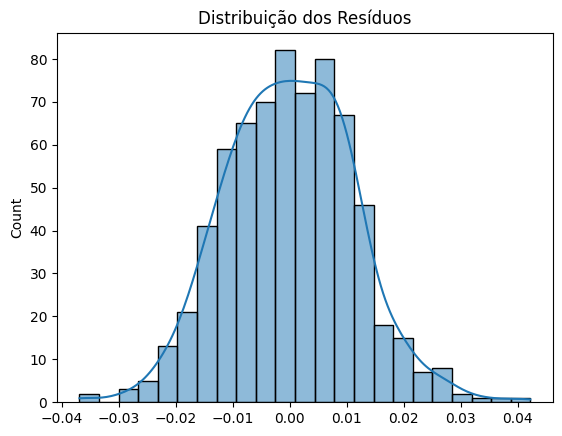

In [120]:
# Histograma dos resíduos
sns.histplot(resid, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

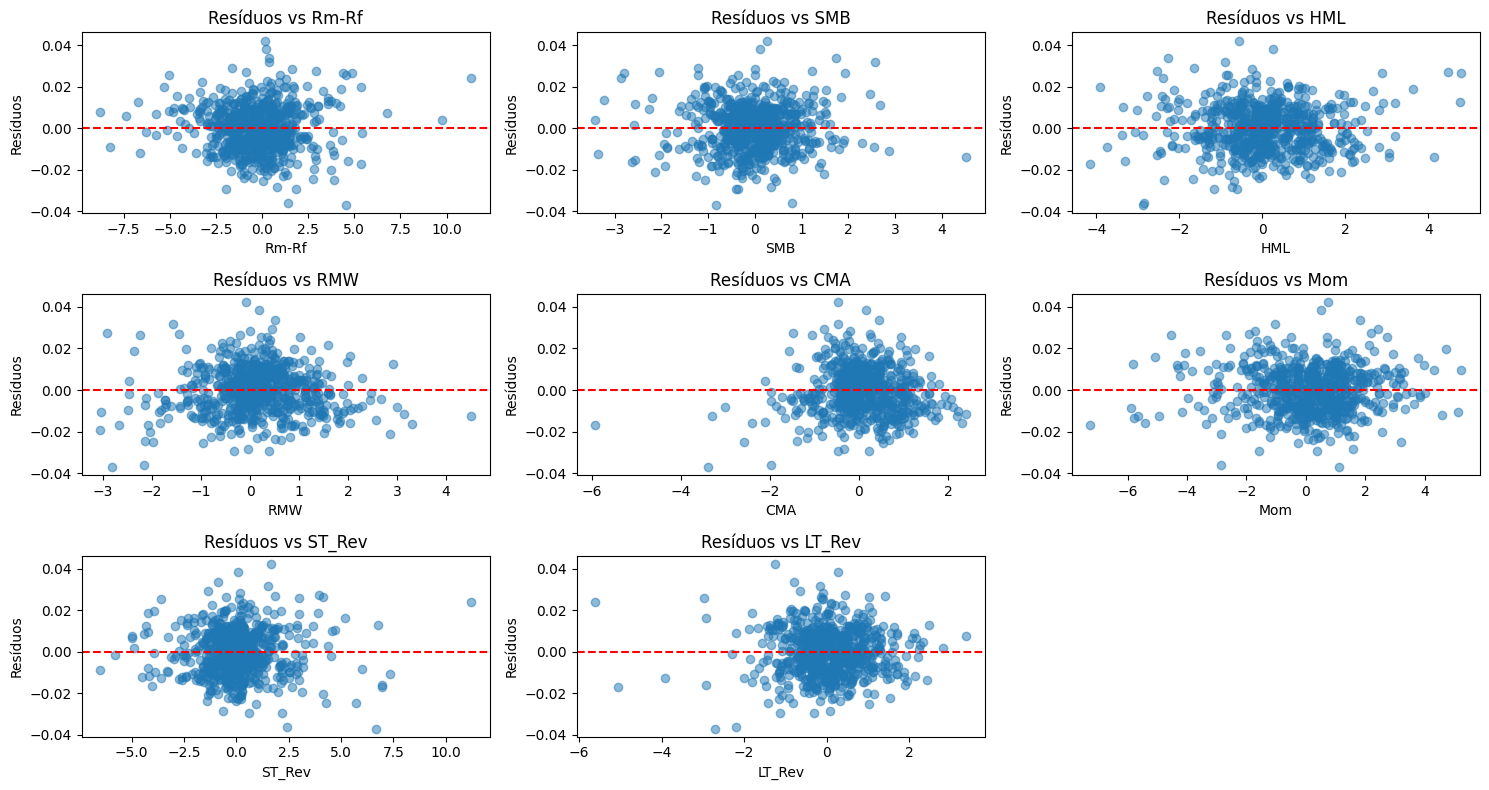

In [121]:
# lista de variáveis explicativas
vars_X = X.columns

# grid de gráficos (ajuste conforme o nº de variáveis)
n = len(vars_X)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(vars_X):
    axes[i].scatter(X[var], resid, alpha=0.5)
    axes[i].axhline(0, color="red", linestyle="--")
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Resíduos")
    axes[i].set_title(f"Resíduos vs {var}")

# remover eixos extras, se houver
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Residuos analisados contra cada variável independentemente, reforça a hipótese de linearidade do modelo.

# 3. Teste Box Cox aplicado à regressao

o Box-Cox transforma a variável dependente Y para que os resíduos do modelo fiquem mais próximos da normalidade e atendam melhor às hipóteses da regressão linear.

In [122]:
# 1. Variável dependente
Y = df["ExcessRet"].copy()

# 2. Verifica se há valores não positivos
if np.any(Y <= 0):
    # Estratégia correta: shift proporcional baseado na magnitude dos dados
    # Exemplo: move o conjunto de dados para cima usando |min(Y)| + 10% da amplitude
    min_val = Y.min()
    range_val = Y.max() - Y.min()
    shift = abs(min_val) + 0.1 * range_val
    Y_shifted = Y + shift
    print(f" Aplicado shift proporcional: +{shift:.6f}")
else:
    shift = 0
    Y_shifted = Y

# 3. Aplica Box-Cox
Y_bc, lambda_bc = stats.boxcox(Y_shifted)
print("Lambda Box-Cox:", lambda_bc)

# 4. Regressão com Y transformado
X = df[["Rm-Rf", "SMB", "HML", "RMW", "CMA", "Mom", "ST_Rev", "LT_Rev"]]
X_const = sm.add_constant(X)
model_bc = sm.OLS(Y_bc, X_const).fit()

print(model_bc.summary())

 Aplicado shift proporcional: +0.058318
Lambda Box-Cox: 0.8184273264026772
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.673
Date:                Thu, 16 Oct 2025   Prob (F-statistic):              0.102
Time:                        17:18:22   Log-Likelihood:                 1696.8
No. Observations:                 679   AIC:                            -3376.
Df Residuals:                     670   BIC:                            -3335.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

## 3.1 observando os residuos do modelo após ajuste do teste box cox

In [123]:
resid_bc = model_bc.resid  # resíduos
fitted_bc = model_bc.fittedvalues  # valores ajustados

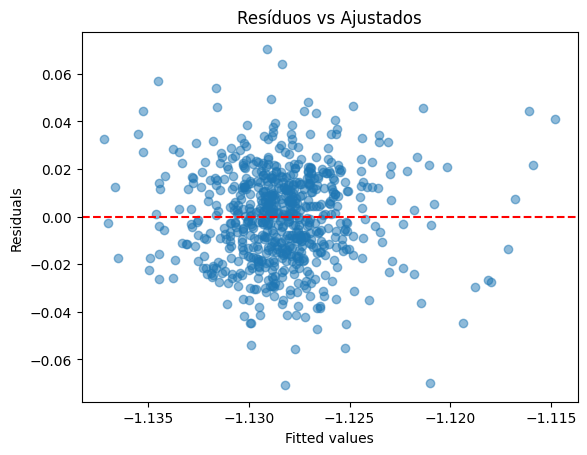

In [124]:
# Resíduos vs Valores Ajustados
plt.scatter(fitted_bc, resid_bc, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Resíduos vs Ajustados")
plt.show()


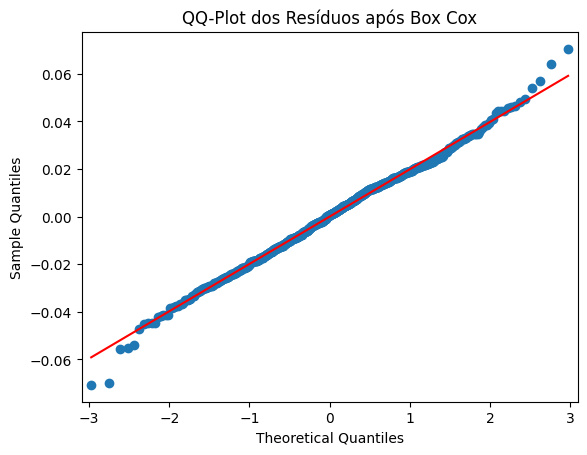

In [125]:

# QQ-plot (checando normalidade)
sm.qqplot(resid_bc, line="s")
plt.title("QQ-Plot dos Resíduos após Box Cox")
plt.show()



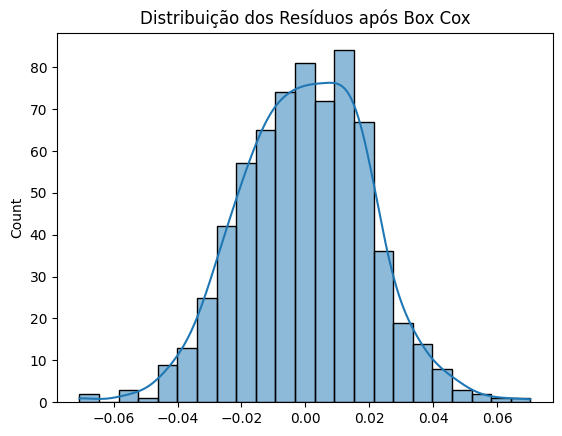

In [126]:
# Histograma dos resíduos
sns.histplot(resid_bc, kde=True)
plt.title("Distribuição dos Resíduos após Box Cox")
plt.show()

Dado que o lambda obtido no Box Cox foi 0.8184, ou seja, próximo a 1, e os resultados após ajuste nao demosntraram melhora quando plotados, optei por nao aplicar a transformação. 

O modelo inicialmente escolhido, será o "model", não o "model_bc".

# 4. Seleção do Modelo

## 4.1 Seleção por forward

In [127]:
# criando função forward

def forward_selection(X, Y, criterion="aic"):
    best_features = []
    remaining_features = list(X.columns)
    best_score = np.inf
    
    while remaining_features:
        scores = []
        for feature in remaining_features:
            trial_features = best_features + [feature]
            X_const = sm.add_constant(X[trial_features])
            model = sm.OLS(Y, X_const).fit()
            score = model.aic if criterion=="aic" else model.bic
            scores.append((score, feature, trial_features))
        
        scores.sort()
        best_new_score, best_new_feature, best_new_features = scores[0]
        
        if best_new_score < best_score:
            best_score = best_new_score
            best_features = best_new_features
            remaining_features.remove(best_new_feature)
        else:
            break
    
    # 🔑 Ajusta o modelo final só com as variáveis finais
    X_const = sm.add_constant(X[best_features])
    final_model = sm.OLS(Y, X_const).fit()
    
    return final_model, best_features



In [128]:
# Forward Selection usando AIC
forward_model, forward_features = forward_selection(X, Y, criterion="aic")
print("Forward Selection (AIC):", forward_features)
print(forward_model.summary())



Forward Selection (AIC): ['ST_Rev', 'SMB']
                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.979
Date:                Thu, 16 Oct 2025   Prob (F-statistic):            0.00267
Time:                        17:18:25   Log-Likelihood:                 2085.6
No. Observations:                 679   AIC:                            -4165.
Df Residuals:                     676   BIC:                            -4152.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

In [129]:
# Forward Selection usando BIC
forward_model, forward_features = forward_selection(X, Y, criterion="bic")
print("Forward Selection (BIC):", forward_features)

print(forward_model.summary())

Forward Selection (BIC): ['ST_Rev']
                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     8.329
Date:                Thu, 16 Oct 2025   Prob (F-statistic):            0.00403
Time:                        17:18:25   Log-Likelihood:                 2083.8
No. Observations:                 679   AIC:                            -4164.
Df Residuals:                     677   BIC:                            -4155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0

## 4.2 Seleção por backward

In [130]:
# criando função backward

def backward_selection(X, Y, criterion="aic"):
    features = list(X.columns)
    best_score = np.inf
    best_features = features[:]  # copia inicial
    
    while features:
        scores = []
        for feature in features:
            trial_features = [f for f in features if f != feature]
            X_const = sm.add_constant(X[trial_features])
            model = sm.OLS(Y, X_const).fit()
            score = model.aic if criterion=="aic" else model.bic
            scores.append((score, trial_features))
        
        scores.sort()
        best_new_score, best_new_features = scores[0]
        
        if best_new_score < best_score:
            best_score = best_new_score
            features = best_new_features
            best_features = best_new_features
        else:
            break
    
    # 🔑 Ajusta o modelo final só com as variáveis finais
    X_const = sm.add_constant(X[best_features])
    final_model = sm.OLS(Y, X_const).fit()
    
    return final_model, best_features



In [131]:
# Backward Selection usando AIC
backward_model, backward_features = backward_selection(X, Y, criterion="aic")
print("Backward Selection (AIC):", backward_features)
print(backward_model.summary())

Backward Selection (AIC): ['SMB', 'ST_Rev']
                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.979
Date:                Thu, 16 Oct 2025   Prob (F-statistic):            0.00267
Time:                        17:18:25   Log-Likelihood:                 2085.6
No. Observations:                 679   AIC:                            -4165.
Df Residuals:                     676   BIC:                            -4152.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

In [132]:
# Backward Selection usando BIC
backward_model, backward_features = backward_selection(X, Y, criterion="bic")
print("Backward Selection (BIC):", backward_features)
print(backward_model.summary())

Backward Selection (BIC): ['ST_Rev']
                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     8.329
Date:                Thu, 16 Oct 2025   Prob (F-statistic):            0.00403
Time:                        17:18:25   Log-Likelihood:                 2083.8
No. Observations:                 679   AIC:                            -4164.
Df Residuals:                     677   BIC:                            -4155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -

O critério AIC, tanto através de backward e forward, sugere usar o as variáveis SMB e ST_Rev.

O critério BIC, tanto através de backward e forward, sugere usar apenas a variável ST_Rev.

O modelo escolhido através de BIC valoriza a simplicidade e evita overfitting.
O modelo escolhido através de AIC privilegia menor erro de previsão, mesmo que mantenha algumas variáveis menos relevantes.

Neste caso, optarei pelo modelo AIC.

# 5. Teste de Multicolinearidade

## 5.1 calculo de VIF

In [136]:
# Calcula VIF
vif_data = pd.DataFrame()
vif_data["variavel"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)

  variavel       VIF
0    const  1.063835
1    Rm-Rf  2.071350
2      SMB  1.346819
3      HML  2.591922
4      RMW  2.544361
5      CMA  2.803074
6      Mom  1.923728
7   ST_Rev  1.868707
8   LT_Rev  2.525572


## 5.2 Calculo do número e índice de condição

In [137]:
# Decomposição em valores singulares
_, s, _ = np.linalg.svd(X_const)

# Índices de condição
condition_index = max(s) / min(s)
print("Número de Condição:", condition_index)

condition_indices = s.max() / s
print("Índices de Condição:", condition_indices)

Número de Condição: 6.552221140636245
Índices de Condição: [1.         1.56328356 2.14686255 2.33404606 2.52226098 2.96308609
 4.22146239 5.32813855 6.55222114]


## 5.3 observação das correlaçãoes das variáveis independentes

In [138]:
print(X.corr())

           Rm-Rf       SMB       HML       RMW       CMA       Mom    ST_Rev  \
Rm-Rf   1.000000 -0.146734 -0.097082 -0.461433 -0.483281 -0.415138  0.602026   
SMB    -0.146734  1.000000  0.026631 -0.260966  0.064179  0.149329  0.034938   
HML    -0.097082  0.026631  1.000000  0.317244  0.523626 -0.322179 -0.188560   
RMW    -0.461433 -0.260966  0.317244  1.000000  0.616596  0.180767 -0.503534   
CMA    -0.483281  0.064179  0.523626  0.616596  1.000000  0.207641 -0.507731   
Mom    -0.415138  0.149329 -0.322179  0.180767  0.207641  1.000000 -0.222124   
ST_Rev  0.602026  0.034938 -0.188560 -0.503534 -0.507731 -0.222124  1.000000   
LT_Rev -0.380611  0.352383  0.476359  0.100265  0.531127  0.276344 -0.328744   

          LT_Rev  
Rm-Rf  -0.380611  
SMB     0.352383  
HML     0.476359  
RMW     0.100265  
CMA     0.531127  
Mom     0.276344  
ST_Rev -0.328744  
LT_Rev  1.000000  


Como os valores de VIF são menores que 5, o número de condição é 6 (baixo), os índices de condição são menores que 30 e as correlações baixas, concluí-se que não há multicolinearidade no modelo.

# 6. Diagnósticos do Modelo

## 6.1 Verificando outliers (resíduos studentizados/padronizados)

**Resíduo studentizado**

Resíduo padronizado pelo erro-padrão ajustado da observação, ajustando a influência própria.

Análise: Usado para detectar outliers (variável dependente).

Métrica: Valores ∣ti∣>2 (ou>3 em amostras grandes) indicam possíveis outliers.

**Resíduo padronizado**

Resíduo dividido pelo erro-padrão estimado do modelo, ajustado pelo leverage (H[i,i]) da observação.

Análise: Usado para avaliar discrepâncias nos erros, sem excluir a influência própria da observação.

Métrica: Valores ∣Zi∣>2 (ou >3 em amostras grandes) indicam possíveis outliers, mas com menor precisão que os resíduos studentizados.

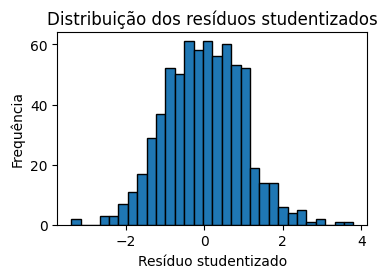

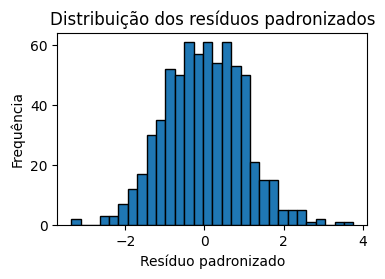

In [139]:
influence = model.get_influence()

resid_student = influence.resid_studentized_external  # resíduos studentizados
resid_standard = influence.resid_studentized_internal # resíduos padronizados

plt.figure(figsize=(4,2.5))
plt.hist(resid_student, bins=30, edgecolor='black')
plt.title("Distribuição dos resíduos studentizados")
plt.xlabel("Resíduo studentizado")
plt.ylabel("Frequência")
plt.show()


plt.figure(figsize=(4,2.5))
plt.hist(resid_standard, bins=30, edgecolor='black')
plt.title("Distribuição dos resíduos padronizados")
plt.xlabel("Resíduo padronizado")
plt.ylabel("Frequência")
plt.show()


## 6.2 Análise de alavangaem via matriz H

**Matriz H (leverage)**

Mede quanto uma observação é extrema no espaço das variáveis explicativas (o quanto cada observação[i] contribui para a estimativa de sua própria previsão Y^i[i]). 

Análise: Calcula-se o valor diagonal H[i,i] da matriz chapéu.

Métrica: Média esperada é p/n. 
Valores hii>2p/n ou 3p/n indicam alto leverage (potencial influência).

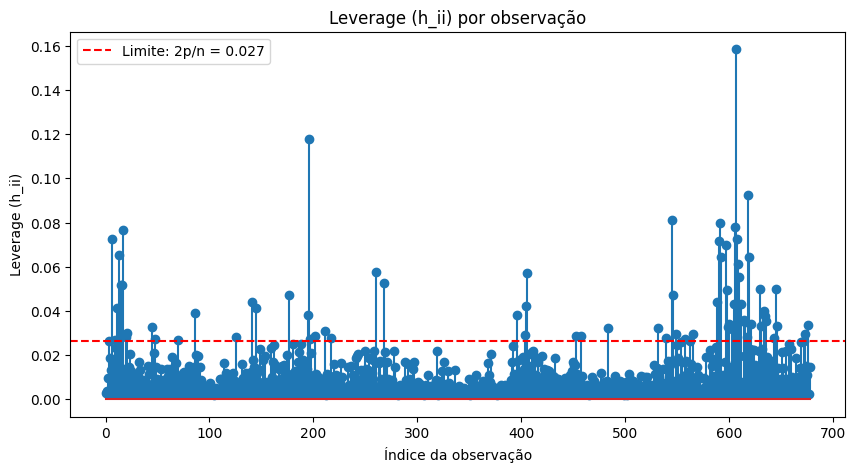

In [140]:
leverage = model.get_influence().hat_matrix_diag

# criar o gráfico
plt.figure(figsize=(10,5))
plt.stem(np.arange(len(leverage)), leverage)
plt.title("Leverage (h_ii) por observação")
plt.xlabel("Índice da observação")
plt.ylabel("Leverage (h_ii)")

# linha de referência: limite típico de leverage alto
n = X_const.shape[0]  # número de observações
p = X_const.shape[1]  # número de parâmetros
limite = 2 * p / n
plt.axhline(y=limite, color='r', linestyle='--', label=f'Limite: 2p/n = {limite:.3f}')

plt.legend()
plt.show()

## 6.3 DFFIT, DFBETA e COVRATIO

**DFFITS**

Mede quanto a previsão Y^i muda se a observação i for retirada do modelo.

Análise: Combina leverage e resíduo studentizado.

Métrica: Observação é influente se ∣DFFITSi∣>2p/n

**DFBETAS**

Mede quanto o coeficiente βj muda ao remover a observação i.

Análise: Calcula o impacto ponto a ponto sobre cada parâmetro.

Métrica: ∣DFBETAij∣>2/n sugere influência relevante da observação sobre βj.

**COVRATIO**

Mede o efeito da exclusão de uma observação sobre a variância conjunta dos estimadores.

Análise: Compara determinante da matriz de covariância com e sem a observação.

Métrica: Valores fora do intervalo [1−3p/n,1+3p/n] indicam observações influentes.

In [141]:
# extrair métricas
dffits, _ = influence.dffits
dfbetas = influence.dfbetas
covratio = influence.cov_ratio
leverage = influence.hat_matrix_diag
student_resid = influence.resid_studentized_external

# criar DataFrame com DFFITS, COVRATIO, leverage e resíduo
diagnostico = pd.DataFrame({
    "DFFITS": dffits,
    "COVRATIO": covratio,
    "Leverage (h_ii)": leverage,
    "Resíduo studentizado": student_resid
})

# adicionar DFBETAS (uma coluna por coeficiente)
for i, col in enumerate(model.params.index):
    diagnostico[f"DFBETA_{col}"] = dfbetas[:, i]

# visualizar as primeiras observações
print(diagnostico.head(10))

     DFFITS  COVRATIO  Leverage (h_ii)  Resíduo studentizado  DFBETA_const  \
0 -0.079324  0.988093         0.002968             -1.453925     -0.060139   
1 -0.056041  1.005361         0.003596             -0.932842     -0.035671   
2 -0.028603  1.021983         0.009415             -0.293392     -0.007610   
3 -0.310633  0.992218         0.026308             -1.889773     -0.045161   
4 -0.117723  1.022614         0.018585             -0.855477     -0.026719   
5 -0.077027  1.020955         0.013182             -0.666465     -0.031671   
6 -0.323321  1.073193         0.072430             -1.157037     -0.026664   
7 -0.207690  0.993057         0.015722             -1.643335     -0.051220   
8  0.022256  1.026328         0.012967              0.194171      0.007352   
9 -0.102770  1.036344         0.027003             -0.616901     -0.024350   

   DFBETA_Rm-Rf  DFBETA_SMB  DFBETA_HML  DFBETA_RMW  DFBETA_CMA  DFBETA_Mom  \
0      0.000826    0.013044   -0.030492    0.021473    0.00820

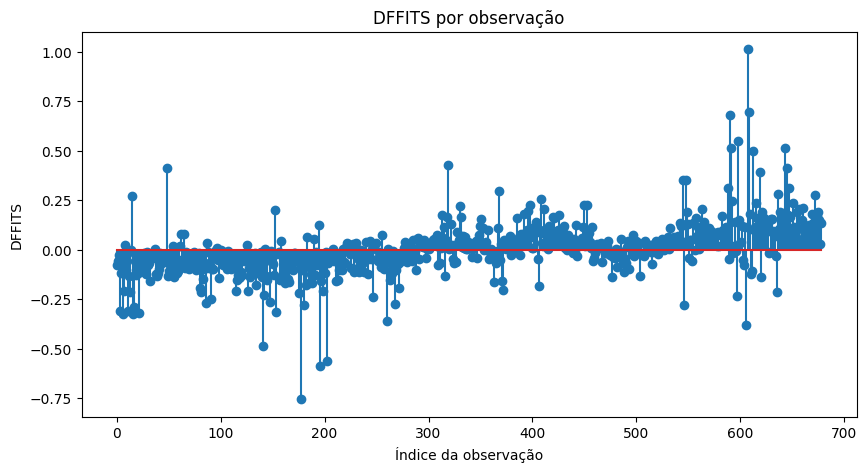

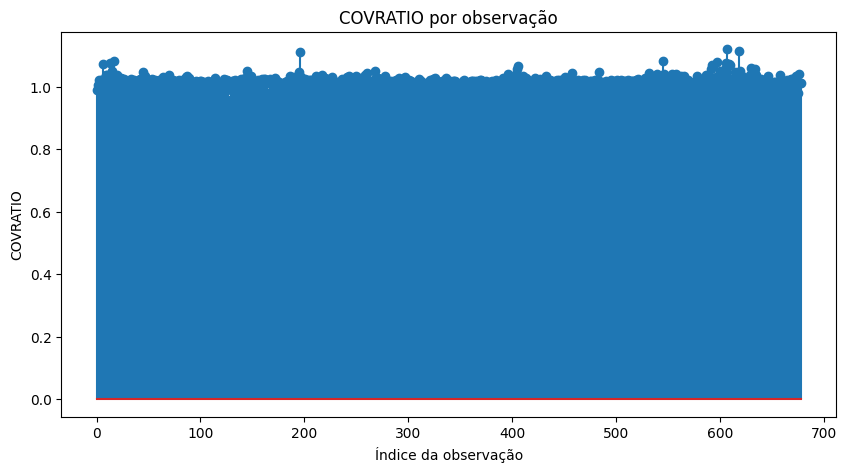

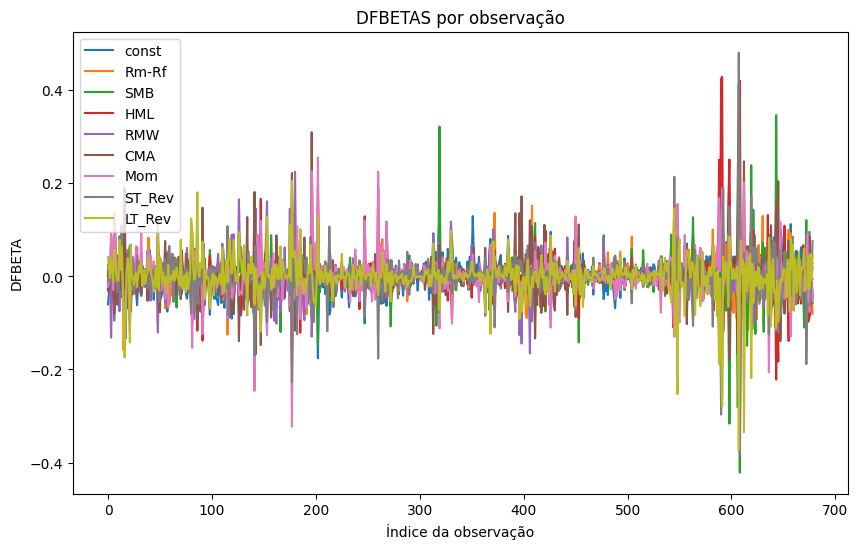

In [142]:
# Gráfico de DFFIT 
plt.figure(figsize=(10,5))
plt.stem(np.arange(len(dffits)), dffits)
plt.title("DFFITS por observação")
plt.xlabel("Índice da observação")
plt.ylabel("DFFITS")
plt.show()


# Gráfico de COVRATIO
plt.figure(figsize=(10,5))
plt.stem(np.arange(len(covratio)), covratio)
plt.title("COVRATIO por observação")
plt.xlabel("Índice da observação")
plt.ylabel("COVRATIO")
plt.show()


# Gráfico de DFBETAS
dfbetas = influence.dfbetas
dfbetas_df = pd.DataFrame(dfbetas, columns=model.params.index)

plt.figure(figsize=(10,6))
for col in dfbetas_df.columns:
    plt.plot(dfbetas_df.index, dfbetas_df[col], label=col)

plt.title("DFBETAS por observação")
plt.xlabel("Índice da observação")
plt.ylabel("DFBETA")
plt.legend()
plt.show()

# 7. Teste de autocorrelação dos resíduos

## 7.1 Correção de Newey-West sobre os residuos do modelo candidato ExcessRet ~ ST_Rev + SMB (model_adj)

O teste de NW corrige heterocedasticidade apra avaliação dos resíduos.

In [143]:
Y = df["ExcessRet"]
X_adj = df[["ST_Rev","SMB"]]
X_adj_const = sm.add_constant(X_adj)


model_adj = sm.OLS(Y, X_adj_const).fit()

In [144]:
# aplicar correção Newey-West com 6 defasagens
nw_model_adj = model_adj.get_robustcov_results(cov_type='HAC', maxlags=6)

print(nw_model_adj.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.928
Date:                Thu, 16 Oct 2025   Prob (F-statistic):             0.0542
Time:                        17:18:42   Log-Likelihood:                 2085.6
No. Observations:                 679   AIC:                            -4165.
Df Residuals:                     676   BIC:                            -4152.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0148      0.001    -17.701      0.0

## 7.2 Teste de ljung-box sobre o modelo candidato Excess ~ ST_Rev + SMB, após correção de hetorocedasticidade


In [152]:
# resíduos do modelo 
resid_adj= nw_model_adj.resid

# Teste de Ljung–Box para defasagens 9 a 25
ljung_box_adj = acorr_ljungbox(resid_adj, lags=list(range(9, 25)), return_df=True)
print(ljung_box_adj)

        lb_stat      lb_pvalue
9   1315.376382  1.477024e-277
10  1441.043737  1.361821e-303
11  1576.353853   0.000000e+00
12  1708.049874   0.000000e+00
13  1838.007517   0.000000e+00
14  1972.573255   0.000000e+00
15  2090.557356   0.000000e+00
16  2226.786214   0.000000e+00
17  2367.290301   0.000000e+00
18  2505.882478   0.000000e+00
19  2633.621714   0.000000e+00
20  2730.673276   0.000000e+00
21  2837.667332   0.000000e+00
22  2957.054721   0.000000e+00
23  3076.392527   0.000000e+00
24  3181.858927   0.000000e+00


## 7.3 FAC e FACP dos residuos

In [146]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

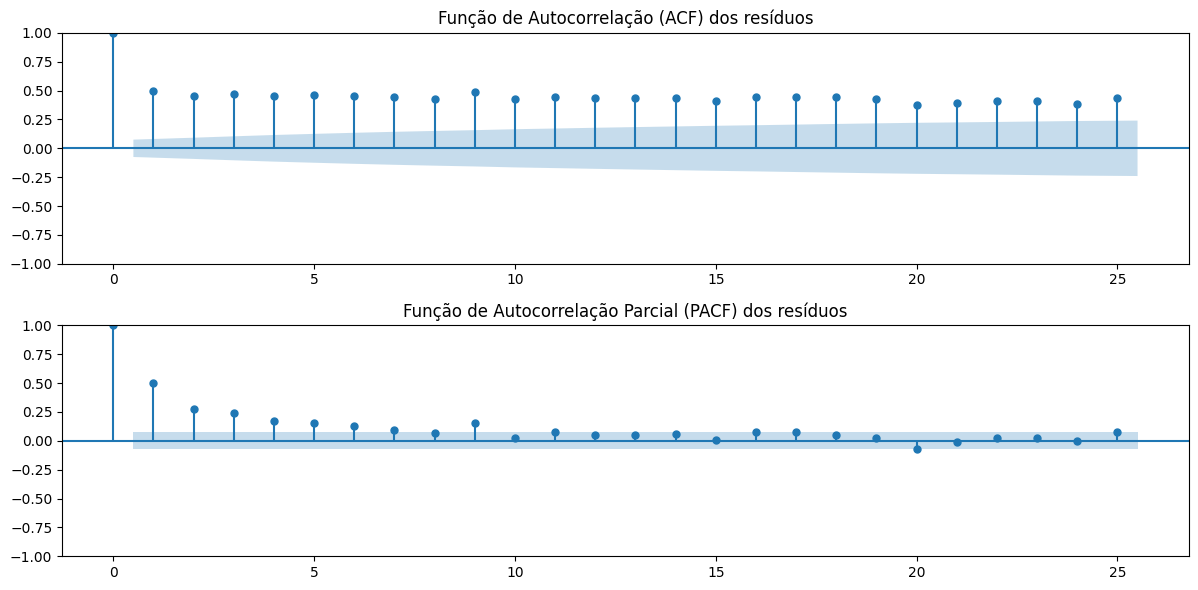

In [147]:
plt.figure(figsize=(12,6))

# ACF
plt.subplot(2,1,1)
plot_acf(resid_adj, lags=25, ax=plt.gca())
plt.title("Função de Autocorrelação (ACF) dos resíduos")

# PACF
plt.subplot(2,1,2)
plot_pacf(resid_adj, lags=25, ax=plt.gca(), method="ywm")
plt.title("Função de Autocorrelação Parcial (PACF) dos resíduos")

plt.tight_layout()
plt.show()

# 8. Importância Relativa dos Regressors


na consegui instalar o pacote "dominance_analysis", pois não é compatível com a versão atualizada de numpy

**Importância relativa dos regressores:** Contribuição média de cada X ao R2 total (Shapley approximation)

In [149]:
if not hasattr(np, "bool"):
    np.bool = bool
if not hasattr(np, "int"):
    np.int = int
if not hasattr(np, "float"):
    np.float = float

def shapley_r2(y, X):
    """
    Calcula a importância relativa dos regressores (LMG / Shapley R²),
    equivalente ao calc.relimp(..., type="lmg", rela=TRUE) no R.
    Compatível com NumPy 2.x
    """
    vars_ = list(X.columns)
    k = len(vars_)
    shapley_values = {v: 0 for v in vars_}

    for var in vars_:
        others = [v for v in vars_ if v != var]
        for j in range(len(others) + 1):
            for subset in itertools.combinations(others, j):
                subset = list(subset)
                model_with = sm.OLS(y, sm.add_constant(X[subset + [var]])).fit()
                if subset:
                    model_without = sm.OLS(y, sm.add_constant(X[subset])).fit()
                    r2_without = model_without.rsquared
                else:
                    r2_without = 0
                r2_with = model_with.rsquared
                weight = math.factorial(len(subset)) * math.factorial(k - len(subset) - 1) / math.factorial(k)
                shapley_values[var] += weight * (r2_with - r2_without)

    # normaliza para soma = 1
    total = sum(shapley_values.values())
    shapley_values = {k: v / total for k, v in shapley_values.items()}
    return pd.Series(shapley_values, name="Relative Importance (LMG)")

In [150]:
Y = df["ExcessRet"]
X = df[["ST_Rev", "SMB"]]

importance = shapley_r2(Y, X)
print("\nImportância relativa (LMG):")
print(importance)


Importância relativa (LMG):
ST_Rev    0.714942
SMB       0.285058
Name: Relative Importance (LMG), dtype: float64


# 9. Resultados

**Modelo Final** Excess Return ~ SMB + ST_Rev

In [80]:
Y = df["ExcessRet"]
X = df[["ST_Rev","SMB"]]
X_const = sm.add_constant(X)


model = sm.OLS(Y, X_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              ExcessRet   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.979
Date:                Tue, 14 Oct 2025   Prob (F-statistic):            0.00267
Time:                        16:53:47   Log-Likelihood:                 2085.6
No. Observations:                 679   AIC:                            -4165.
Df Residuals:                     676   BIC:                            -4152.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0148      0.000    -34.353      0.0

# 10. Conclusões

**Conclusões acerca dos diagnósticos:** 

- Resíduos Studentizados: as premissas de normalidade parecem satisfeitas, sem valores extremos em Y.
- Matriz Chapéu: muitos valores com alto valor de alavancagem, indicando serem altos em X. 
- DFBETA: em muitas variávies, alguns valores pontuais afetam de forma significativa a estimativa de Y.
- DFFITS: em muitas variávies, alguns valores pontuais afetam de forma significativa a estimativa do coeficiente.


**Modelo final escolhido:** O modelo final escolhido foi Excess ~ SMB + ST_Rev. 

- **R² = 0.017:** indica que o modelo tem baixo valor explicativo quanto à variação de Y.

- **p(F) = 0.00267:** indica que, apesar do baixo poder explicativo, o modelo é estatisticamente significativo, sua variação não é por acaso.


- **coeficiente Small Minus Big estimado = -0.0010:** O coeficiente é ligeiramente negativo, ou seja, o ativo tem uma leve inclinação para o comportamento de grandes empresas (big caps).

- **coeficiente ST_Rev estimado= 0.0008:** Há um comportamento positivo relacionao ao Short Term Reverse. Ações tendem a ter um comportamento inverso do observado a curto prazo.

- **a constante estimada = -0.0148:** representa o retorno médio do ativo que nao é explicado pelas variáveis.






**Conclusões acerca dos testes de autocorrelação dos resíduos:**
- Ljung-Box: valore próximo a zero indicam que há autocorrelação nos resíduos, quando analisados sob diferentes cenaários de H0.

**A Importância relativa (LMG) dos Regressores:**
- ST_Rev: 71,49%
- SMB: 28.51%

## CONCLUSÃO GERAL DO MODELO ##

Através da regressao CAPM com 8 fatores, não é possivel explicar a variação de "Rp_vw_fi - Risk Free" de maneira robusta. 

Conforme a análise residual sugere, é necessário observar a série de excessos de retorno através de modelos que considerem fatores temporais.